# Bearing failure Anomaly Detection
---

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
    * Data 전처리 및 EDA
    * 시계열 데이터 특성 추출(옵션)
    * 이상 탐지 모델링

## **문제상황 및 데이터 살펴보기**
- 문제상황
---
- B사는 냉장고를 생산하는 업체이다. 냉장고 제작 공정은 컨베이어 벨트 방식으로 제작이 되며, 하나의 공정이 중단될 시 모든 공정이 All stop되는 매우 심각한 특성을 가진다. 
- 냉장고를 제작하는데 있어 주요 공정인 조립설비는 Bearing을 핵심 부품으로 사용한다. Bearing은 사용할 수록 마모가 되어 주기적으로 변경을 해줘야하는 부품 특성을 가지고 있다. 
- B사는 Bearing이 파손되기 이전에 이상점을 감지하여 사전 유지보수(구리스, 윤활제)를 통해 All stop을 사전에 방지하고자 한다.
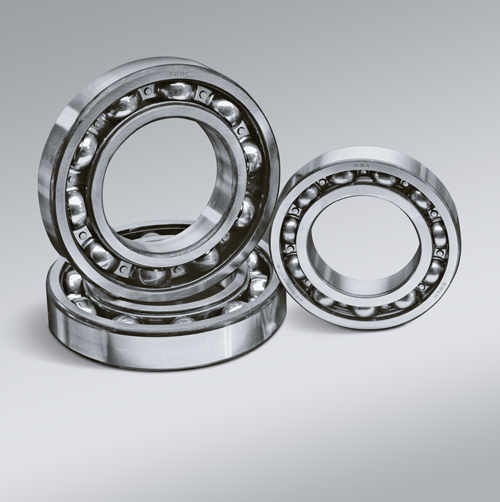

데이터 살펴보기
- Bearing Sensor data
- 데이터 명세

|Column|Description|
|:---|:---|
|index|측정 시간 Index|
|Bearing 1|베어링 1 진동 센서 값|
|Bearing 2|베어링 2 진동 센서 값|
|Bearing 3|베어링 3 진동 센서 값|
|Bearing 4|베어링 4 진동 센서 값|




In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [38]:
# # 10분 단위 파일 불러오기
# data_dir = "./bearing_data"  # /와 \를 잘 구분해서 사용바람.
# merged_data = []

# for filename in os.listdir(data_dir):
#     dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')  # 파일 하나를 읽어온다.
#     dataset_mean_abs = np.array(dataset.abs().mean())                  # 파일에서 컬럼별로 절대값을 구하고 평균을 구한다.
#     dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))     # reshape을 통해 1 by 4 형태로 구성하고 데이터프레임화 한다.
#     dataset_mean_abs.index = [filename]                                # 파일이름을 인덱스로 설정한다. 
#     merged_data.append(dataset_mean_abs)
    
# merged_data = pd.concat(merged_data, axis=0)
# merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [39]:
# # index를 시간형태로 변환
# merged_data['time'] = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
# merged_data = merged_data.set_index('time')
# merged_data = merged_data.sort_index()  # index를 기준으로 정렬
# merged_data.to_csv('10min_Averaged_BearingTest_Dataset.csv')
# print("Dataset shape:", merged_data.shape)

In [2]:
df = pd.read_csv("10min_Averaged_BearingTest_Dataset.csv")

df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('time')


## 문제해결 프로세스 정의
---
1) 문제정의
- 냉장고 공정 주요 조립설비의 고장이 발생하면 Line All stop 리스크(고장나서 라인스탑되면 베어링 교체하고 다시 돌리면 안되나? 라인스탑되면 생산이 늦어지고 납기가 늘어나고, 지연에 대한 소비자 불만 등으로 이어진다.)
- 조립설비의 핵심 부품인 Bearing 마모에 따른 설비 고장

2) 기대효과 (우리가 문제를 해결하면 뭐가 좋을까?)
- 설비고장 사전에 방지하여, Line stop 방지(설비가 쉬는 시간에 점검하자)
- Line stop으로 인한 점검 시간 및 비용 절감
- 계획 대비 생산량 달성

3) 해결방안 (사실 활용가능한 방법을 생각해봐야 한다, 현업의 로직활용, 경험에 의한 방법, 모델링에 의한 방법 등을 정하고 우선순위를 만든 후 달성 가능한 방법을 생각해봐야 한다).
- 베어링 센서 데이터 이상탐지를 통해 사전 고장발생 방지
    - Data 전처리 및 EDA 
    - 시계열 센서 데이터 분석 
    - 이상탐지 모델링 

4) 성과측정
- 모델 활용 전/후 Line stop 횟수 비교
- 모델 활용 전/후 계획 대비 생산률 비교

5) 현업적용
- Bearing Sensor Data 실시간 수집 체계 구축
- Model에 Input할 window time 결정 (예: 샘플링 주기가 1초인데, 이를 15분 정도 데이터가 모이면 평균화 해보자)
- Sensor Data Model Input 및 Alarm, 대시보드 만들기
- Anomaly Points 발견 시 유휴시간 장비 점검

## Data 전처리 및 EDA

### Data 전처리  
- 수집된 데이터의 기본 정보들을 확인  

  (1) Data shape(형태) 확인  
  (2) Data type 확인  
  (3) Null값 확인 (※ 빈 값의 Data)  
  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)    

In [3]:
# Data 형태 확인
# 982 row, 5 col로 구성됨
df.shape

(982, 4)

In [4]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2004-02-12 10:52:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  982 non-null    float64
 1   Bearing 2  982 non-null    float64
 2   Bearing 3  982 non-null    float64
 3   Bearing 4  982 non-null    float64
dtypes: float64(4)
memory usage: 38.4 KB


In [5]:
# Null 값 확인
df.isna().sum()

Bearing 1    0
Bearing 2    0
Bearing 3    0
Bearing 4    0
dtype: int64

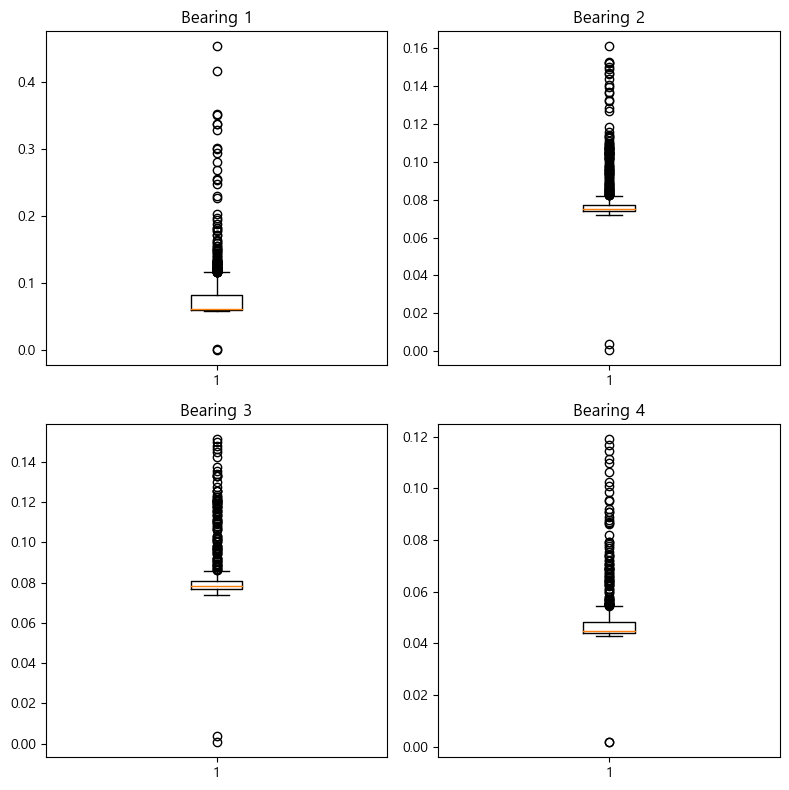

In [6]:
# Outlier 확인
plt.figure(figsize=(8, 8))
for i, column in enumerate(df.columns):
    plt.subplot(2, 2, i + 1)
    plt.title(column)
    plt.boxplot(df[column])
plt.tight_layout()
plt.show()

### Data EDA
---
* 데이터 특성 파악을 위한 초기 탐색

In [7]:
# 전체 Data 기간 확인
tmp = df.reset_index()
tmp['day'] = tmp['time'].dt.day
tmp.groupby(['day']).mean()

,time,Bearing 1,Bearing 2,Bearing 3,Bearing 4
day,,,,,
12,2004-02-12 17:22:39.000000128,0.061368,0.075735,0.081286,0.044181
13,2004-02-13 11:57:39.000000000,0.060592,0.075524,0.079026,0.044004
14,2004-02-14 11:57:39.000000000,0.060825,0.074674,0.077362,0.044098
15,2004-02-15 11:57:39.000000000,0.060866,0.073891,0.076758,0.043896
16,2004-02-16 11:57:39.000000000,0.070525,0.074101,0.076843,0.044733
17,2004-02-17 11:57:39.000000000,0.092714,0.076770,0.078121,0.048640
18,2004-02-18 11:57:39.000000000,0.113726,0.087240,0.090122,0.054233
19,2004-02-19 03:12:38.999999872,0.218299,0.117683,0.117943,0.082463


In [270]:
df.plot(backend='plotly', kind='bar')

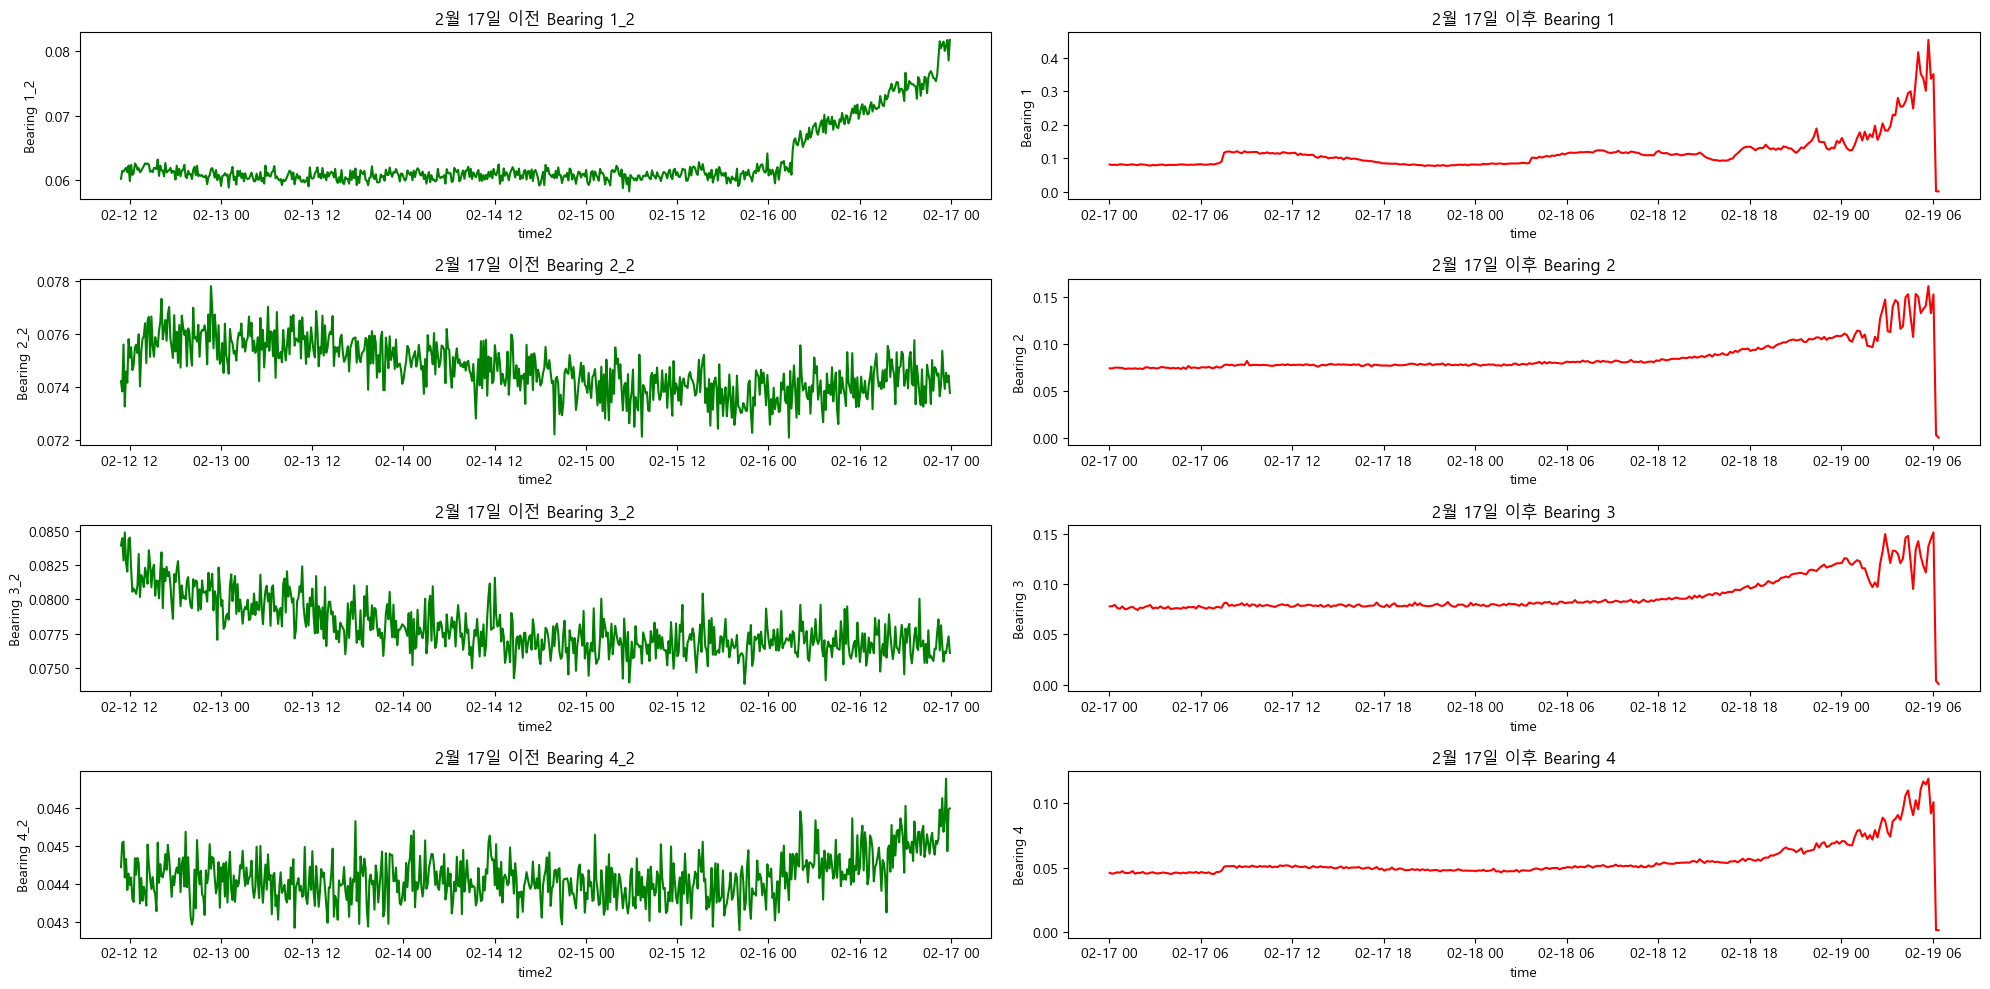

In [8]:
# Plotting 전체 데이터 

# 뒷부분에서 고장이 발생된 듯 함.
# 2004년 2월 17일을 기준으로 나눠보자.
under17 = df.loc[:'2004-02-16'].reset_index().rename(columns={'time':'time2', 'Bearing 1':'Bearing 1_2', 'Bearing 2':'Bearing 2_2', 'Bearing 3':'Bearing 3_2', 'Bearing 4':'Bearing 4_2'})
upper17 = df.loc['2004-02-17':].reset_index()
tmp = pd.concat([under17, upper17], axis=1)
co = ['Bearing 1_2', 'Bearing 1', 'Bearing 2_2', 'Bearing 2', 'Bearing 3_2', 'Bearing 3', 'Bearing 4_2', 'Bearing 4', 'time2', 'time']
tmp = tmp[co]
tmp


plt.figure(figsize=(20, 10))
for i, column in enumerate(tmp.columns[:-2]):
    plt.subplot(4,2, i+1)
    if i % 2 == 0:
        sns.lineplot(x=tmp['time2'], y=tmp[column], color='g')
        plt.title('2월 17일 이전 ' + column)
    else:
        sns.lineplot(x=tmp['time'], y=tmp[column], color='r')
        plt.title('2월 17일 이후 ' + column)
plt.tight_layout()
plt.show()
# df.loc['2004-02-17':]

In [ ]:
# Before Data 기간 확인

# 1번 베어링은 2월 16일쯤에서 부터 커진다.

In [ ]:
# ▶ After Data 기간 확인

# 베어링 2,3,4는 2월 19일부터 문제가 있어 보임.
# 베어링 1, 2, 3, 4에 대해 어느 정도 이상탐지를 위한 방법이 보이는 것 같음. 
# 베어링간 상관관계는 없다고 했으니, 단변량 이상탐지 방법도 가능

## 시계열 데이터 특성 추출(옵션)

### Date 관련 변수 추출

In [ ]:
# 년, 월, 요일, 시간
# [참조] x.year, x.month, x.day, x.hour, x.minute, x.second, x.microsecond, x.weekday()


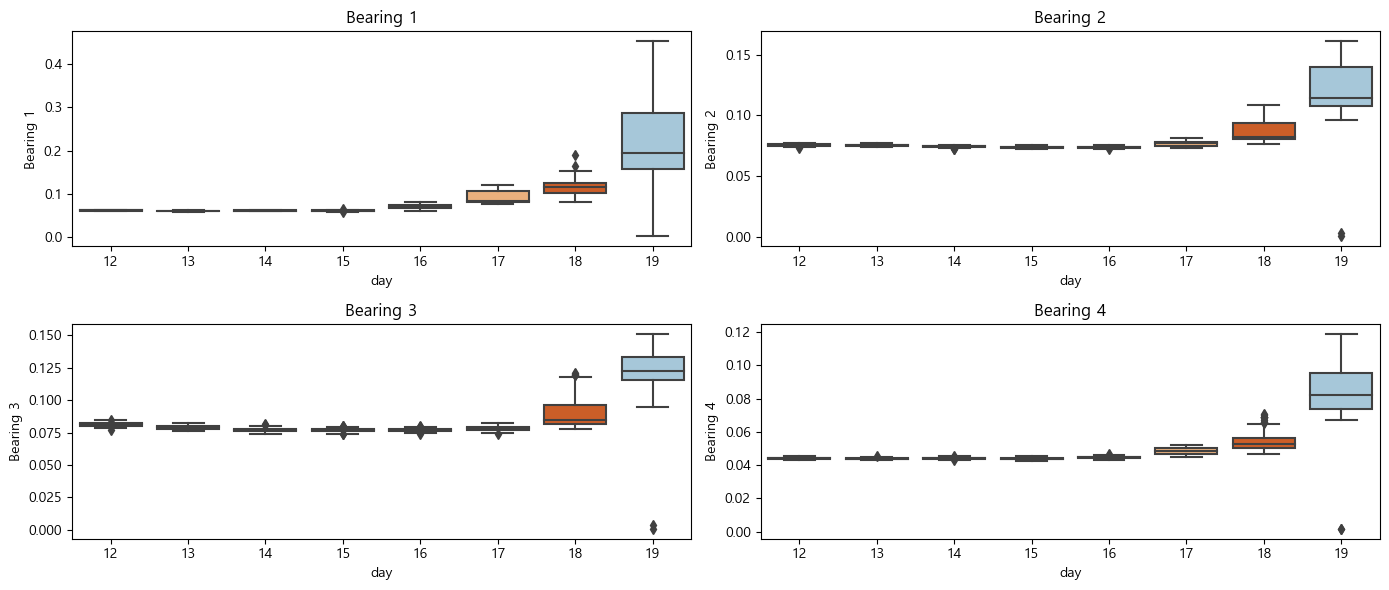

In [10]:
# ▶ Box plot 활용 일 별 Bearing 분포 확인
df['day'] = df.index.day

plt.figure(figsize=(14, 6))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='day', y=column, data=df, palette='tab20c_r')
    plt.title(column)
plt.tight_layout()
plt.show()
df.drop('day', axis=1, inplace=True)

### lag(지연) 데이터 생성
* 시계열 데이터에서 이전에 값을 고려할 때 lag(지연) 데이터를 사용, shift() 활용

In [11]:
# shift 명령어 사용 ,lag 데이터 생성
df.shift(periods=2)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:52:39,NaN,NaN,NaN,NaN
2004-02-12 11:02:39,NaN,NaN,NaN,NaN
2004-02-12 11:12:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:22:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:32:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.338265,0.136772,0.118172,0.116861
2004-02-19 05:52:39,0.301344,0.140436,0.111463,0.114495
2004-02-19 06:02:39,0.453335,0.161016,0.137440,0.119047


In [12]:
# 'fill_value' = 0 옵션을 통해 NaN 값 처리
df.shift(2, fill_value=0)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:52:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:02:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:12:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:22:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:32:39,0.061361,0.075609,0.082837,0.045118
...,...,...,...,...
2004-02-19 05:42:39,0.338265,0.136772,0.118172,0.116861
2004-02-19 05:52:39,0.301344,0.140436,0.111463,0.114495
2004-02-19 06:02:39,0.453335,0.161016,0.137440,0.119047


In [ ]:
# ▶ Shift(n)을 통해 지연 기간 조정 가능


### 이동 평균(Rolling window)
---
* smoothing 효과

In [13]:
# rolling 명령어 사용 이동 평균 생성
df.rolling(window=3).mean()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:52:39,NaN,NaN,NaN,NaN
2004-02-12 11:02:39,NaN,NaN,NaN,NaN
2004-02-12 11:12:39,0.061018,0.074560,0.083740,0.044881
2004-02-12 11:22:39,0.061494,0.074244,0.084058,0.044791
2004-02-12 11:32:39,0.061656,0.074493,0.083447,0.044650
...,...,...,...,...
2004-02-19 05:42:39,0.364315,0.146075,0.122358,0.116801
2004-02-19 05:52:39,0.364087,0.144617,0.131298,0.108556
2004-02-19 06:02:39,0.380676,0.148561,0.144577,0.103996


In [14]:
# NaN 값 처리 
df.rolling(window=3).mean().fillna(0)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,
2004-02-12 10:52:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:02:39,0.000000,0.000000,0.000000,0.000000
2004-02-12 11:12:39,0.061018,0.074560,0.083740,0.044881
2004-02-12 11:22:39,0.061494,0.074244,0.084058,0.044791
2004-02-12 11:32:39,0.061656,0.074493,0.083447,0.044650
...,...,...,...,...
2004-02-19 05:42:39,0.364315,0.146075,0.122358,0.116801
2004-02-19 05:52:39,0.364087,0.144617,0.131298,0.108556
2004-02-19 06:02:39,0.380676,0.148561,0.144577,0.103996


## 이상 탐지 모델링

### · Model Selection
---
* PCA Anomaly Detection
```
# 여러 변수 간에 존재하는 상관관계를 이용하여 이를 대표한 주성분을 추출해 차원을 축소하는 기법
# 기존 데이터의 유실을 최소하 하기 위해 데이터의 분산을 최대화 할 수 있는 초평면(Hyper plane)을 찾고 데이터를 투영함
# Auto encoder와 작동원리가 비슷함
# 다중공선성을 제거하기 위해 각 벡터의 축이 직각이 되도록 투영 시킴
# 원본 데이터의 Feature 개수에 비해 매우 적은 주성분으로 원본 데이터의 총 변동성을 대부분 설명할 수 있는 분석법
```
<img src = "https://drive.google.com/uc?id=16dNJTSMUiFmk4wQtJ7hP3HmL0wUy1vgP">

* 장단점
```
  # [good] 고차원에 데이터를 저차원에 주성분으로 표현할 수 있음
  # [good] 선택한 변수들의 해석이 용이함
  # [bad] 변수간 상관관계 고려가 어려움 
  # [bad] 추출된 변수의 해석이 어려움 (※ 주성분, PC1/PC2 ...)
```

### · 차원축소 및 변수 설명력 확인
---

In [3]:
df_h3 = df.shift(18, fill_value=0)
df = pd.concat([df, df_h3], axis=1)
df = df.iloc[18:, :]
df

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 1,Bearing 2,Bearing 3,Bearing 4
time,,,,,,,,
2004-02-12 13:52:39,0.062213,0.075921,0.080896,0.043925,0.060236,0.074227,0.083926,0.044443
2004-02-12 14:02:39,0.062626,0.076406,0.082294,0.043766,0.061455,0.073844,0.084457,0.045081
2004-02-12 14:12:39,0.062514,0.074908,0.081812,0.043427,0.061361,0.075609,0.082837,0.045118
2004-02-12 14:22:39,0.062607,0.076501,0.081133,0.045041,0.061665,0.073279,0.084879,0.044172
2004-02-12 14:32:39,0.062449,0.076648,0.083573,0.044517,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047,0.204114,0.136381,0.132699,0.088846
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125,0.183008,0.146808,0.149630,0.086438
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817,0.182316,0.113392,0.135481,0.077443


In [4]:
df['label'] = 0
df.loc['2004-02-17 00:02:39':, 'label'] = 1
y = df['label']
train = df.loc[:'2004-02-15']
y_train = train['label']
test = df.loc['2004-02-16':]
y_test = test['label']
df = df.drop('label', axis=1)
train.drop('label', axis=1, inplace=True)
test.drop('label', axis=1, inplace=True)

In [5]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, f1_score

def verification_train(y, predict):
    # 성능 평가
    print("Train Accuracy  : ", accuracy_score(y, predict))
    print('f1 score        : ', f1_score(y, predict))
    print('Recall Score    : ', recall_score(y, predict))
    print('precision score : ', precision_score(y, predict))
    print('confusion matrix : ------------------\n', confusion_matrix(y, predict))
    print("\n         --------- Test Classification Report --------")
    print(classification_report(y, predict))

    # 혼동 행렬 시각화
    plt.figure()
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, predict), display_labels=['정상', '이상']).plot(cmap='Blues')
    plt.show()

<Axes: xlabel='time'>

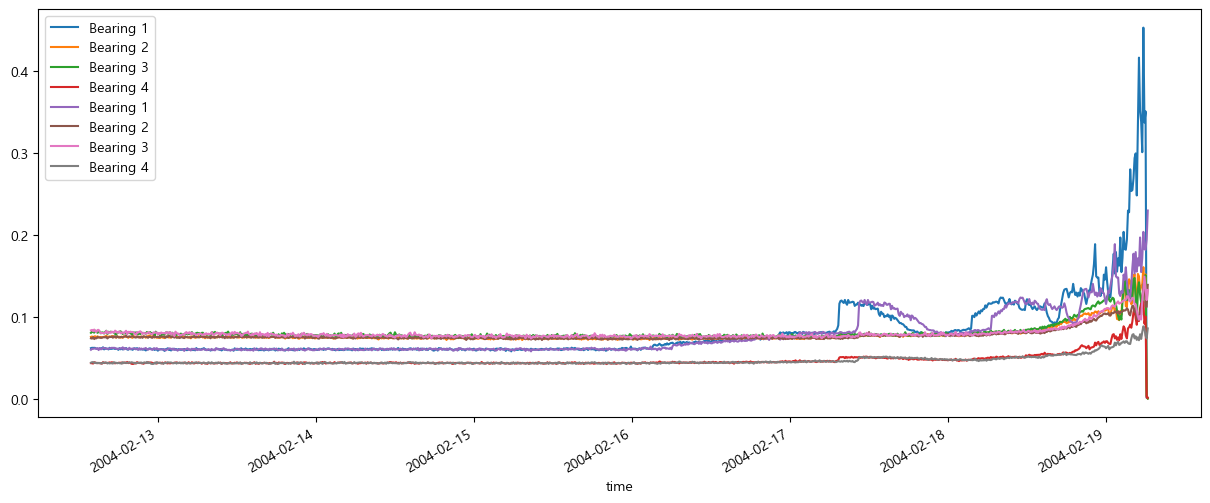

In [88]:
df.plot(figsize=(15,6))

In [199]:
y_test.value_counts()

label
1    327
0    144
Name: count, dtype: int64

In [31]:
std = StandardScaler()
train_sc = std.fit_transform(train)
test_sc = std.transform(test)
std_df = StandardScaler()
df_sc = std_df.fit_transform(df)

In [6]:
# ▶ pca.n_components_(차원 축소 주성분 개수)
pca = PCA()
df_pca = pca.fit_transform(df)

# ▶ pca.explained_variance_ratio_(설명력)
pd.DataFrame(pca.explained_variance_ratio_)

# ▶ PC0, PC1으로도 전체 분산에 95% 이상 설명 가능

,0
0,0.890910
1,0.068205
2,0.029216
3,0.008704
4,0.001539
5,0.000600
6,0.000583
7,0.000243


### · 시각화 및 Threshold 선정
---





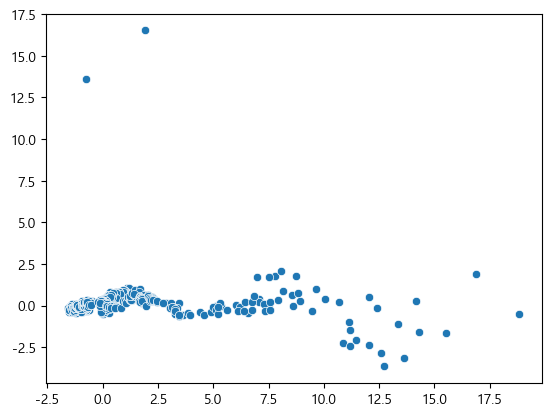

In [205]:
# 2개의 주성분으로 차원 축소
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_sc)
test_pca = pca.transform(test_sc)
pca_df = PCA(n_components=2)
df_pca = pca_df.fit_transform(df_sc)

# 각 클러스터 중심에서 멀리 떨어진 Data 일 수록 이상치
plt.figure()
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1])
plt.show()

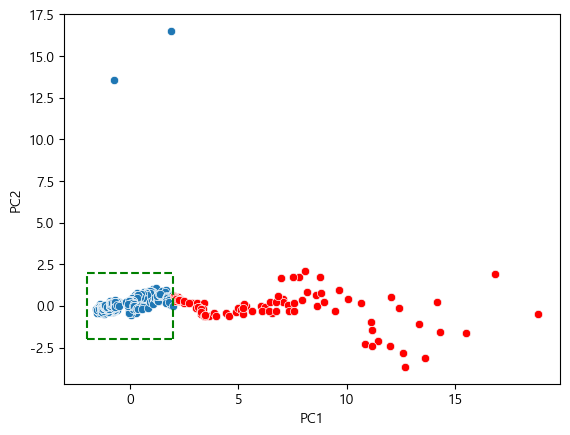

In [206]:
# PC1, PC2인 차원 축소 변수 2, -2를 기준으로 등급을 부여
df_pca_df = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
tmp_idx = df_pca_df[(df_pca_df['PC1'] > 2) | (df_pca_df['PC1'] < -2)].index
plt.figure()
sns.scatterplot(x=df_pca_df['PC1'], y=df_pca_df['PC2'])
sns.scatterplot(x=df_pca_df['PC1'][tmp_idx], y=df_pca_df['PC2'][tmp_idx], color='r')
plt.vlines(2, -2, 2, linestyles='dashed', colors='g')
plt.vlines(-2, -2, 2, linestyles='dashed', colors='g')
plt.hlines(-2, -2, 2, linestyles='dashed', colors='g')
plt.hlines(2, -2, 2, linestyles='dashed', colors='g')
plt.show()

### · Abnormal Labeling
---





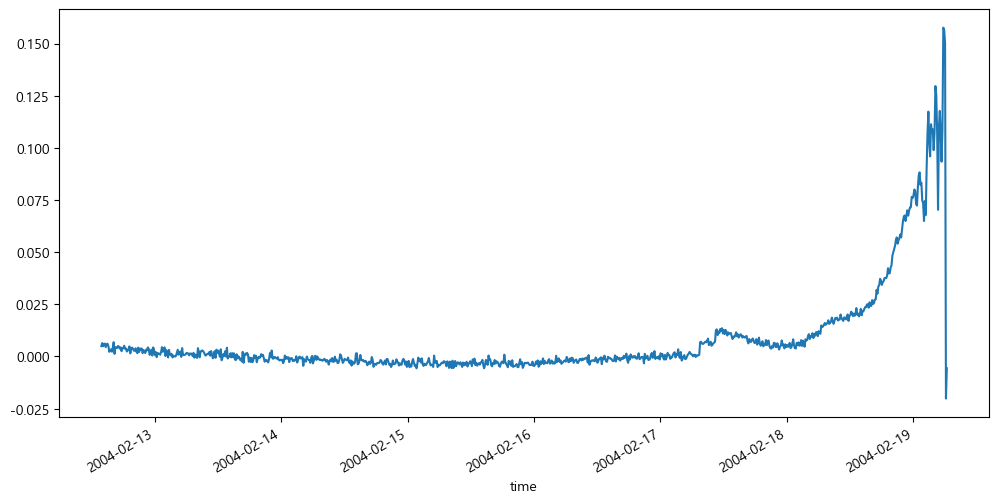

In [207]:
X_train = df[:'2004-02-14']
X_test = df['2004-02-15':]
 
pca = PCA(n_components=1, random_state=0)
x_train_pca = pd.DataFrame(pca.fit_transform(X_train))
x_train_pca.index = X_train.index
 
x_test_pca = pd.DataFrame(pca.transform(X_test))
x_test_pca.index = X_test.index
 
df_pca = pd.concat([x_train_pca, x_test_pca])
df_pca.plot(figsize = (12, 6))
plt.legend().remove()

<Axes: xlabel='time'>

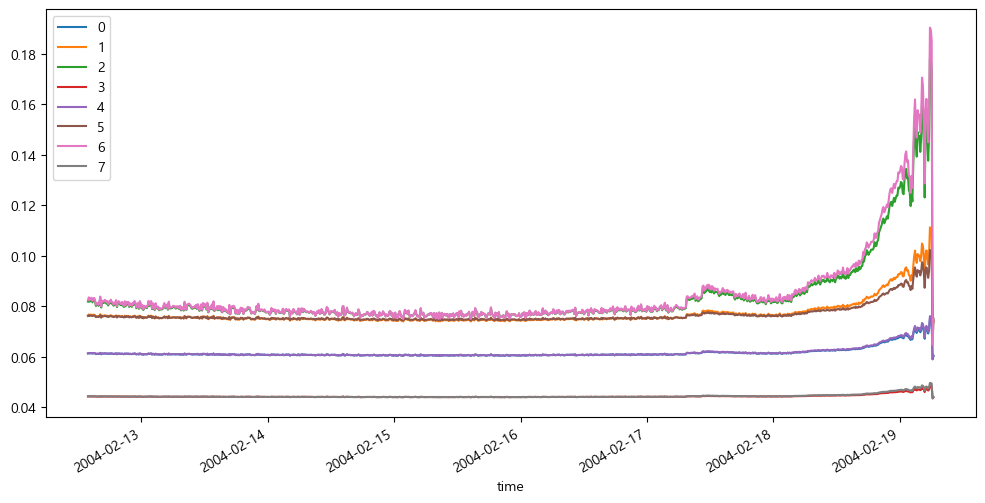

In [208]:
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)
df_restored.plot(figsize = (12, 6))

<Axes: xlabel='time'>

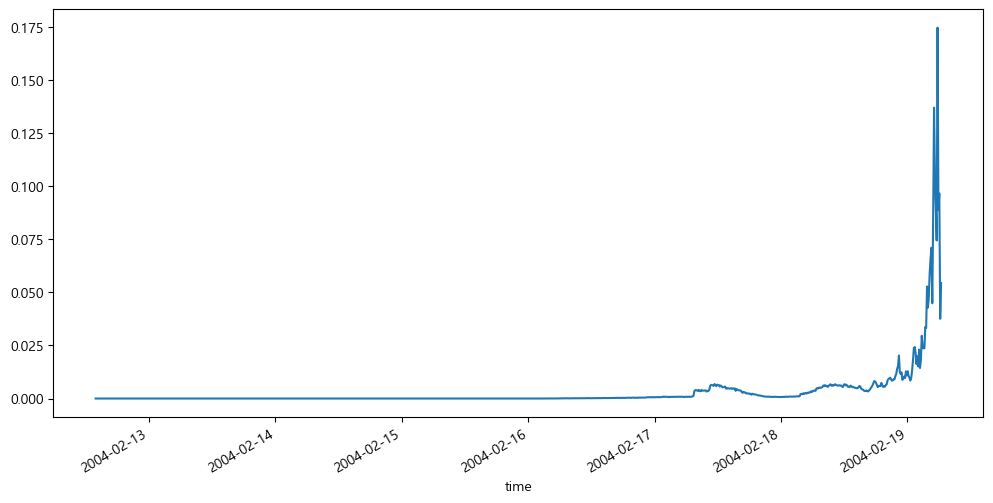

In [209]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss
 
scores = get_anomaly_scores(df, df_restored)
scores.plot(figsize = (12, 6))

In [210]:
def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold

# 기존 Data의 index를 부여
# 기존 data와 Concat
df_pca_label = df.copy()
for index, row in df.iterrows():
    if is_anomaly([row], pca, 0.001):
        df_pca_label.loc[index, 'pca'] = 1
    else:
        df_pca_label.loc[index, 'pca'] = 0

### · 모델 평가
---





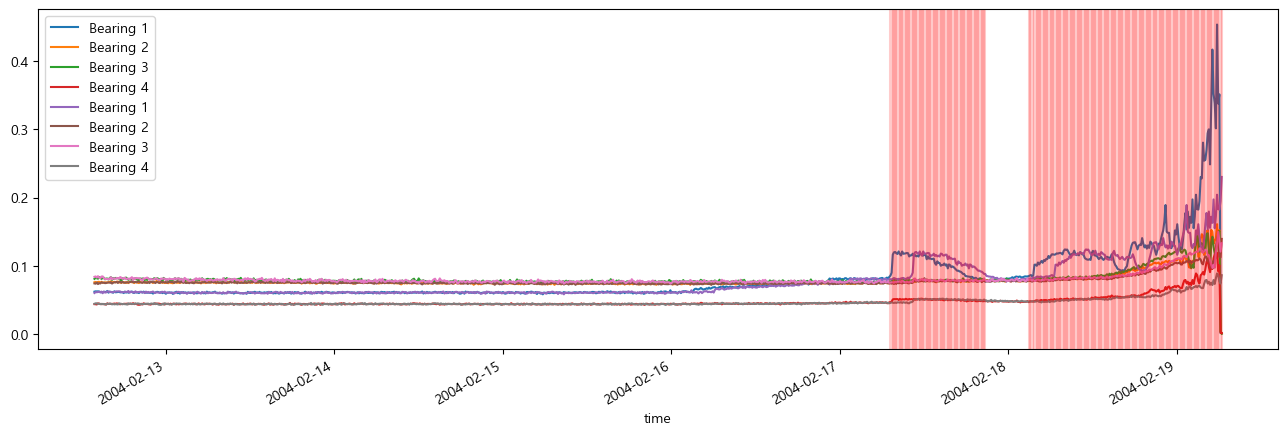

In [211]:
df.plot(figsize = (16, 5))
 
for index, row in df.iterrows():
    if is_anomaly([row], pca, 0.001):
        plt.axvline(row.name, color='r', alpha=0.2)

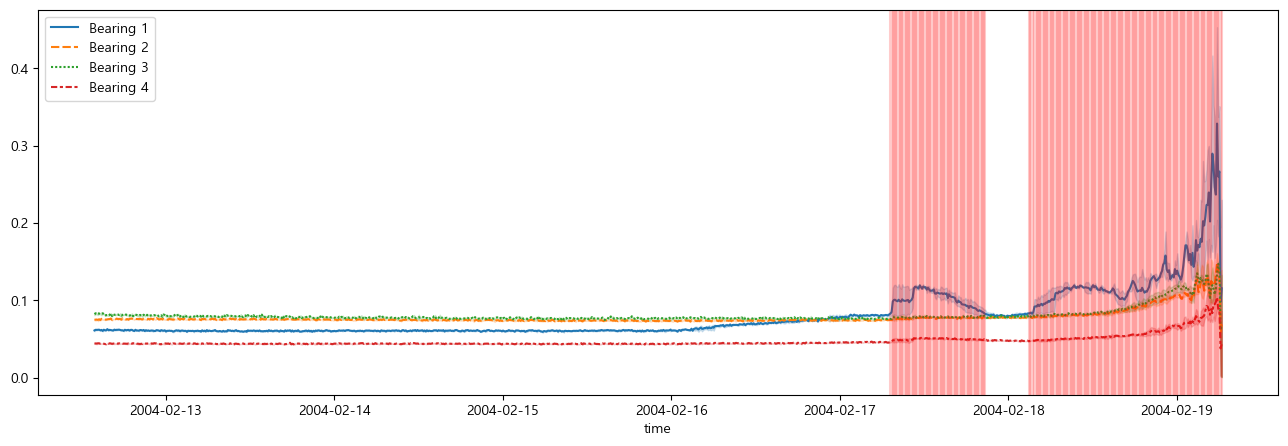

In [212]:
plt.figure(figsize=(16,5))

# 예를 들어, 'value'라는 열을 y로 사용하고자 한다면:
sns.lineplot(df)

# 빨간색 선을 그리기 위해 anomaly가 1인 인덱스를 반복합니다.
for idx in df_pca_label[df_pca_label['pca']==1].index:
    plt.axvline(x=idx, color='red', alpha=0.2)

plt.show()


Train Accuracy  :  0.8301486199575372
f1 score        :  0.8606271777003485
Recall Score    :  0.7553516819571865
precision score :  1.0
confusion matrix : ------------------
 [[144   0]
 [ 80 247]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       144
           1       1.00      0.76      0.86       327

    accuracy                           0.83       471
   macro avg       0.82      0.88      0.82       471
weighted avg       0.89      0.83      0.84       471



<Figure size 640x480 with 0 Axes>

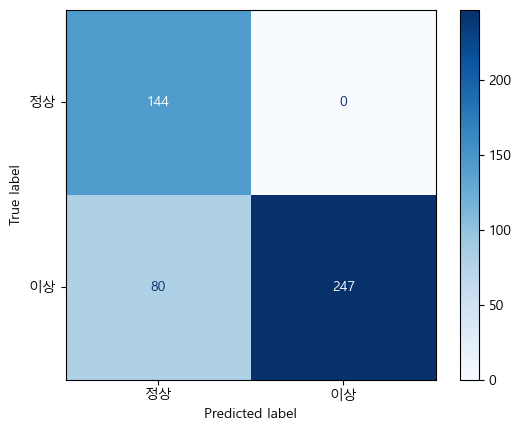

In [213]:
verification_train(y_test, df_pca_label.loc['2004-02-16':]['pca'])

# KMeans

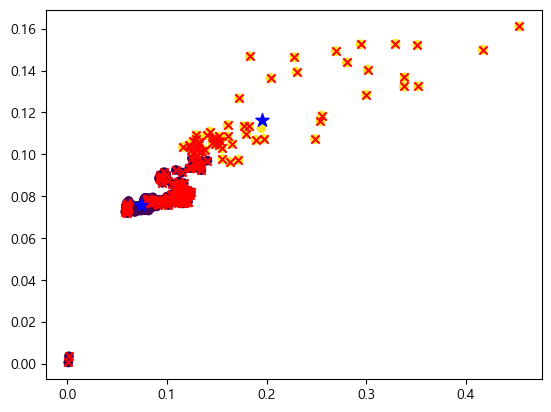

Train Accuracy  :  0.8526970954356846
f1 score        :  0.7694805194805194
Recall Score    :  0.7247706422018348
precision score :  0.8200692041522492
confusion matrix : ------------------
 [[585  52]
 [ 90 237]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       637
           1       0.82      0.72      0.77       327

    accuracy                           0.85       964
   macro avg       0.84      0.82      0.83       964
weighted avg       0.85      0.85      0.85       964



<Figure size 640x480 with 0 Axes>

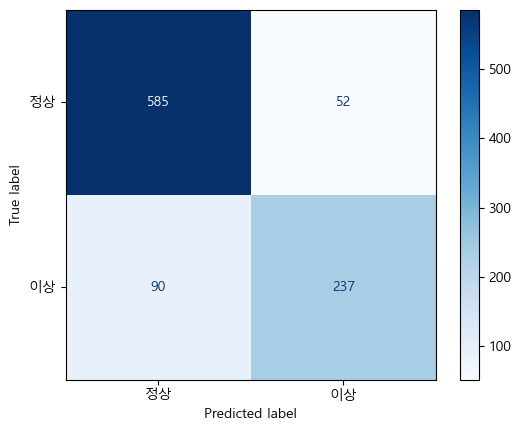

In [32]:
from scipy.spatial.distance import cdist

# 1. KMeans 알고리즘을 사용하여 군집화
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# 2. 각 데이터 포인트에서 해당 클러스터의 중심까지의 거리를 계산
distances = np.linalg.norm(df - centroids[labels], axis=1)

# 3. 거리가 임계값보다 큰 데이터 포인트를 이상치로 판단
threshold = np.percentile(distances, 70)  # 예를 들어, 거리가 상위 5%에 속하는 데이터 포인트를 이상치로 판단
outliers = np.where(distances > threshold)[0]

# 결과 시각화
df_values = df.values
plt.scatter(df_values[:, 0], df_values[:, 1], c=labels)
plt.scatter(df_values[outliers, 0], df_values[outliers, 1], c='red', marker='x')
plt.scatter(centroids[:, 0], centroids[:, 1], c='blue', s=100, marker='*')
plt.show()

# 예측 레이블 생성
predicted_labels = np.where(distances > threshold, 1, 0)  # 1은 이상치, 0은 정상치로 가정

# 성능 평가
report = classification_report(y, predicted_labels)
verification_train(y, predicted_labels)

<Figure size 1600x500 with 0 Axes>

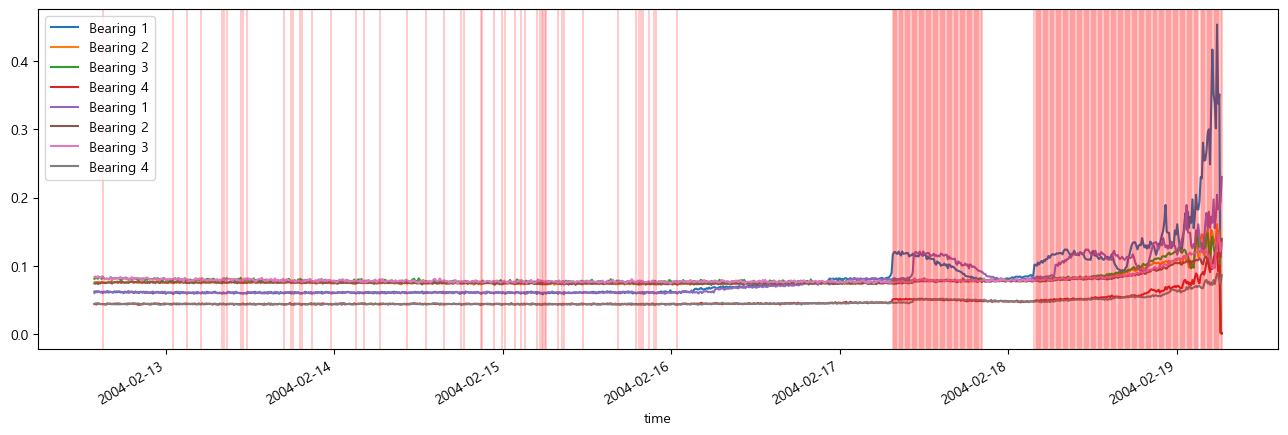

In [33]:
plt.figure(figsize=(16,5))

# 예를 들어, 'value'라는 열을 y로 사용하고자 한다면:
# 주의: 'value'라는 열 이름을 실제 데이터의 열 이름으로 교체해야 합니다.
df.plot(figsize=(16,5))

# 빨간색 선을 그리기 위해 outliers에 해당하는 인덱스를 반복합니다.
for idx in df.index[outliers]:
    plt.axvline(x=idx, color='red', alpha=0.2)

plt.show()


# Isolation

In [235]:
from sklearn.ensemble import IsolationForest

# IsolationForest 모델 학습 (anomaly는 -1, normal은 1로 표현되므로, y 값을 조정)
model = IsolationForest(contamination=0.001, max_features=0.1, max_samples=30, n_estimators=100, random_state=42)
model.fit(train)

# 예측 (-1, 1 값을 1, 0으로 변환)
pred_train = model.predict(train)
pred_test = model.predict(test)
y_pred_train = [1 if pred == -1 else 0 for pred in pred_train]
y_pred_test = [1 if pred == -1 else 0 for pred in pred_test]

In [236]:
pred1 = pd.DataFrame(y_pred_train)
pred2 = pd.DataFrame(y_pred_test)
pred = pd.concat([pred1, pred2], axis=0)
data = df.reset_index()
pred.index = data.index
data = pd.concat([data, pred], axis=1)
data.set_index('time', inplace=True)

<Figure size 1600x500 with 0 Axes>

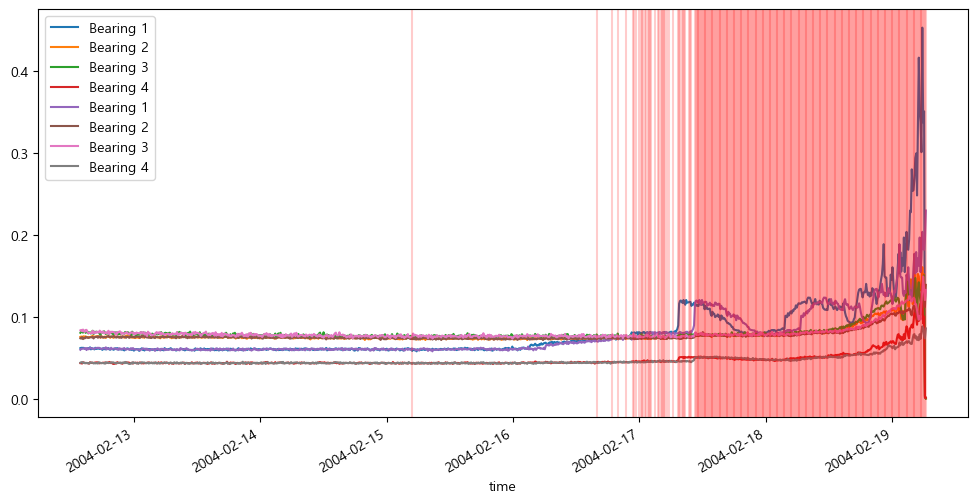

In [237]:
plt.figure(figsize=(16,5))

df.plot(figsize=(12,6))

# 빨간색 선을 그리기 위해 anomaly가 1인 인덱스를 반복합니다.
for idx in data[data[0]==1].index:
    plt.axvline(x=idx, color='red', alpha=0.2)
plt.show()

Train Accuracy  :  0.9129511677282378
f1 score        :  0.9348171701112878
Recall Score    :  0.8990825688073395
precision score :  0.9735099337748344
confusion matrix : ------------------
 [[136   8]
 [ 33 294]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       144
           1       0.97      0.90      0.93       327

    accuracy                           0.91       471
   macro avg       0.89      0.92      0.90       471
weighted avg       0.92      0.91      0.91       471



<Figure size 640x480 with 0 Axes>

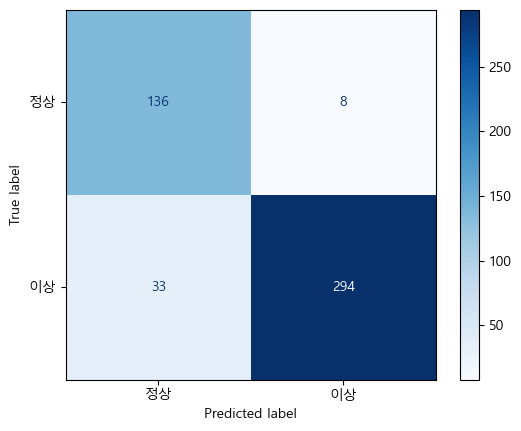

In [238]:
verification_train(y_test, pred2)

In [24]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

n_features = train.shape[1]
latent_dim = 2  # 더 높은 latent_dim을 사용하여 더 많은 정보 압축

# 인코더
enc_inputs = layers.Input(shape=(n_features,))
x = layers.Dense(16, activation='relu')(enc_inputs)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)
x = layers.Dense(2, activation='relu')(x)
enc_outputs = layers.Dense(latent_dim, activation='relu')(x) # Latent vector

encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# 디코더
dec_inputs = layers.Input(shape=(latent_dim,)) # Latent vector
x = layers.Dense(2, activation='relu')(dec_inputs)
x = layers.Dense(4, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
dec_outputs = layers.Dense(n_features, activation='linear')(x) # 데이터를 보고 거기에 맞춰서 활성화 함수 사용 

decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# 오토인코더
inputs = layers.Input(shape=(n_features,))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs=inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='mae', metrics='acc') # 오차 구하는 것 중에 미분이 잘 되는 것 mse
AE.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 8)]               0         
                                                                 
 model_6 (Functional)        (None, 2)                 332       
                                                                 
 model_7 (Functional)        (None, 8)                 338       
                                                                 
Total params: 670
Trainable params: 670
Non-trainable params: 0
_________________________________________________________________


In [25]:
std = StandardScaler()
train_sc = std.fit_transform(train)
test_sc = std.transform(test)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = AE.fit(train_sc,train_sc, validation_split=0.2, batch_size=128, epochs=1000, callbacks=[early_stopping]) # 압축 후 복원하기 때문에, 자신과 비교

Epoch 1/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.7915 - acc: 0.1244 - val_loss: 0.8742 - val_acc: 0.0101
Epoch 2/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7912 - acc: 0.1345 - val_loss: 0.8752 - val_acc: 0.0101
Epoch 3/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7910 - acc: 0.1345 - val_loss: 0.8758 - val_acc: 0.0101
Epoch 4/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7908 - acc: 0.1345 - val_loss: 0.8764 - val_acc: 0.0101
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.7906 - acc: 0.1345 - val_loss: 0.8773 - val_acc: 0.0101
Epoch 6/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.7903 - acc: 0.1345 - val_loss: 0.8784 - val_acc: 0.0101
Epoch 7/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.7901 - acc: 0.1345 - val_loss: 0.8794 - val_acc: 0.0101
Epoch 8/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.7899 - a

In [27]:
p_test = AE.predict(test_sc)
p_test.shape

15/15 [==============================] - 0s 1ms/step


(471, 8)

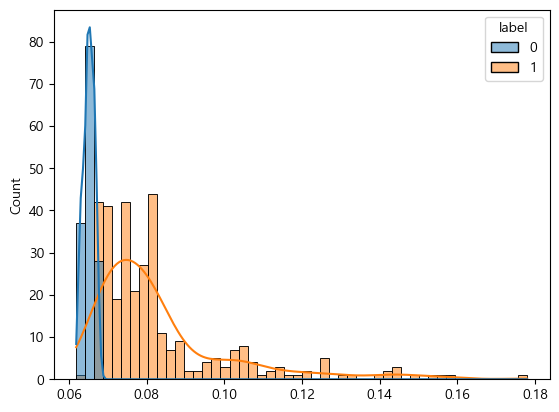

In [28]:
# 재건에러
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=1)

rce = reconstruction_error(test, p_test)

plt.figure()
sns.histplot(x=rce, hue=y_test, bins=50, kde=True)
plt.show()

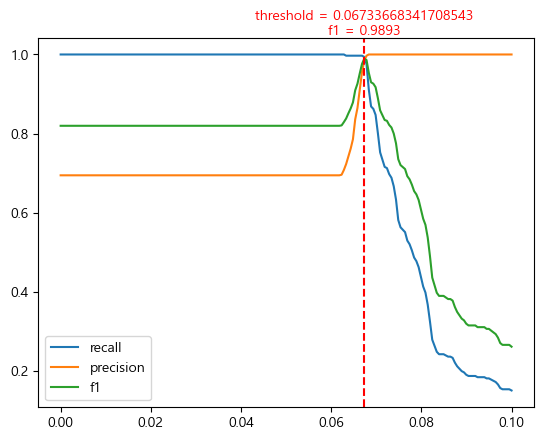

15/15 [==============================] - 0s 2ms/step
Train Accuracy  :  0.9681528662420382
f1 score        :  0.9765990639625585
Recall Score    :  0.9571865443425076
precision score :  0.9968152866242038
confusion matrix : ------------------
 [[143   1]
 [ 14 313]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       144
           1       1.00      0.96      0.98       327

    accuracy                           0.97       471
   macro avg       0.95      0.98      0.96       471
weighted avg       0.97      0.97      0.97       471



<Figure size 640x480 with 0 Axes>

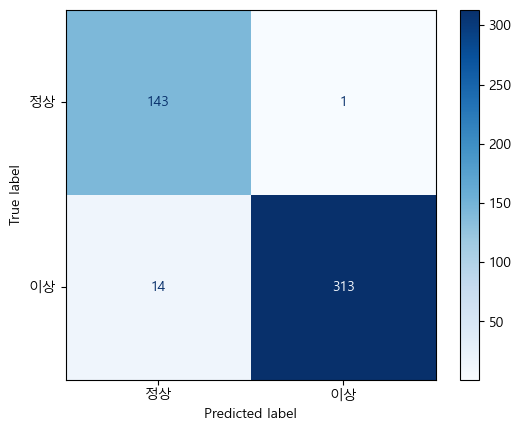

In [34]:
recall = []
precision = []
f1 = []

thresholds = np.linspace(0., 0.1, 200)
# thresholds = np.arange(0 1, 0.01)
for thres in thresholds:
    results = rce > thres
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))


plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

# 오토인코더의 재구성 오차 계산
reconstruction_errors = np.mean(np.square(test - AE.predict(test)), axis=1)

# 이상치 여부 판단 (threshold 이상이면 이상치)
threshold = 0.0048  # 임계치 설정

predicted_outliers = reconstruction_errors > threshold

# 검증 데이터의 실제 이상치 여부
actual_outliers = y_test

verification_train(actual_outliers, predicted_outliers)